In [100]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

In [101]:
# mnist ref:http://yann.lecun.com/exdb/mnist/
# struct ref:https://www.cnblogs.com/gala/archive/2011/09/22/2184801.html
# numpy ref:numpy.org.cn/article/basics/numpy_matrices_vectors.html
def LoadImages(file):
    try:
        F = open(file, 'rb')
    except IOError:
        print("open error")
        F.close()

    f = F.read()

    offset=0
    fmt = '>iiii'
    magic, images, rows, columns = struct.unpack_from(fmt, f, offset)

    offset += struct.calcsize(fmt)
    fmt = '>' + str(rows * columns) + 'B'

    # images = 10 # for test

    # for CNN
    ImageSet = np.empty((images, 1, rows, columns))
    for i in range(images):
        ImageSet[i] = np.array(struct.unpack_from(fmt, f, offset)).reshape((1, rows, columns))
        offset += struct.calcsize(fmt)

    # for simple softmax
    # ImageSet = np.empty((images, rows * columns))
    # for i in range(images):
    #     ImageSet[i] = np.array(struct.unpack_from(fmt, f, offset)).reshape((rows*columns))
    #     offset += struct.calcsize(fmt)

    F.close()

    print(images)

    return ImageSet

In [102]:
def LoadLabels(file):
    try:
        F = open(file, 'rb')
    except IOError:
        print("open error")
        F.close()

    f = F.read()

    offset=0
    fmt = '>ii'

    magic, items = struct.unpack_from(fmt, f, offset)

    offset += struct.calcsize(fmt)
    fmt = '>B'

    # items = 10 # for test

    LabelSet = np.zeros((items, 10))
    for i in range(items):
        LabelSet[i][struct.unpack_from(fmt, f, offset)[0]] = 1
        offset += struct.calcsize(fmt)

    F.close()

    print(items)

    return LabelSet


In [103]:
# test
# im = LoadImages('train-images.idx3-ubyte')
# la = LoadLabels('train-labels.idx1-ubyte')
# plt.ion()
# for i in range(10):
#     plt.imshow(im[i], cmap='Greys')
#     print(la[i])
#     plt.pause(1)

In [104]:
# load training set
TrainImages_np = LoadImages('train-images.idx3-ubyte')
TrainLabels_np = LoadLabels('train-labels.idx1-ubyte')

TrainImages = torch.from_numpy(TrainImages_np)
TrainLabels = torch.from_numpy(TrainLabels_np)

60000
60000


In [105]:
# print(TrainImages)

In [106]:
# x = torch.randn(2,1,7,3)
# print(x)

In [107]:
# test
# print(TrainImages)
# print(TrainLabels)

In [108]:
# softmax with torch
# class SoftmaxNet(nn.Module):
#     def __init__(self, n_feature, n_hidden, n_output):
#         super(SoftmaxNet, self).__init__()
#         self.hidden = nn.Linear(n_feature, n_hidden)
#         self.predict = nn.Linear(n_hidden, n_output)

#     def forward(self, x):
        
#         x = F.relu(self.hidden(x))
#         x = self.predict(x)
#         return F.softmax(x, dim=1)

In [109]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(6, 16, 5)
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.full5 = nn.Linear(16*5*5, 120)
        self.full6 = nn.Linear(120, 84)
        self.out = nn.Linear(84,10)

    def forward(self, x):
        # x = F.relu(self.conv1(x))
        # x = F.relu(self.pool2(x))
        # x = F.relu(self.conv3(x))
        # x = F.relu(self.pool4(x))
        # x = x.view(x.size(0), -1)
        # x = F.relu(self.full5(x))
        # x = F.relu(self.full6(x))
        # x = F.relu(self.out(x))
        # x = F.softmax(x, dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.pool2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool4(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.full5(x))
        x = F.relu(self.full6(x))
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

In [110]:
net = CNN()
print(net)


CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (full5): Linear(in_features=400, out_features=120, bias=True)
  (full6): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)


$$out(N_i, C_{out_j})=bias(C_{out_j})+\sum^{C_{in}-1}{k=0}weight(C{out_j},k)\bigotimes input(N_i,k)$$

In [111]:
losslist = []
timelist = []
# errorlist = []
# errortimelist = []

In [112]:
TrainImages = torch.tensor(TrainImages, dtype=torch.float32)
TrainLabels = torch.tensor(TrainLabels, dtype=torch.float32)

In [113]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.05)
loss_func = nn.MSELoss()

In [114]:
BATCH_SIZE = 64

torch_dataset = D.TensorDataset(TrainImages, TrainLabels)

loader = D.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

for epoch in range(8):
    for step, (batch_x, batch_y) in enumerate(loader):
        
        prediction = net(batch_x)
        loss = loss_func(prediction, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # for test
        if step % 100 == 0:
            print(loss.data.numpy())

        losslist.append(loss.data.numpy())
        timelist.append(step + epoch * 938)

        # print('Epoch: ', epoch, '| Step: ', step, '| batch x: ',
        #       batch_x.numpy(), '| batch y: ', batch_y.numpy())

0.10687772
0.025048772
0.018125635
0.017157536
0.0047271475
0.01335716
0.0037859888
0.011286462
0.0028798613
0.011129187
0.004573402
0.003919649
0.007869927
0.0058651194
0.009259366
0.005534253
0.0053857057
0.009551689
0.0060123713
0.004513773
0.007505612
0.012170718
0.0031027587
0.0025937227
0.0027115347
0.0028611086
0.0025525931
0.014361015
1.7961534e-05
0.012048803
0.0053733806
0.0032649715
0.0011447335
0.006324875
0.0024898308
0.0035045345
0.0014743342
0.0019242965
0.0059981435
0.0067406157
0.002168844
0.0052933926
0.0030611432
0.0010251498
0.001824681
0.00057369214
0.0031653028
0.002921595
0.00019268486
0.0034984774
0.004500138
0.00085785484
0.0021467847
0.004404652
0.00052168453
0.0045784144
0.0019172545
0.00016665358
0.00010606154
0.00050309184
0.009499798
0.00994394
0.0014428527
0.004615627
1.5289233e-05
2.6798905e-05
0.00016925434
0.003334377
0.0037003122
0.00072492764
0.00019547339
0.0001300958
0.0022918233
0.0021204299
0.00011753733
0.0045455424
0.0033451836
0.0010086434
8.4

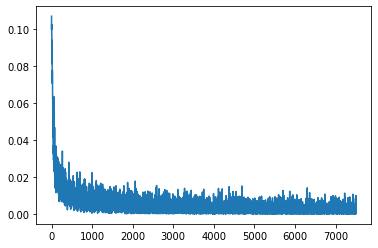

In [115]:
plt.plot(timelist, losslist)

In [116]:
def result(np_array):
    # print(np_array)
    max = np_array[0]
    num = 0
    for i in range(10):
        if np_array[i] > max:
            max = np_array[i]
            num = i
    return num

In [117]:
# plt.ion()
# for i in range(10):
    
    # print((TrainLabels.numpy())[i])
    # print((prediction.detach().numpy())[i])
    # plt.imshow(((TrainImages.numpy())[i]).reshape((28, 28)), cmap='Greys')
    # plt.pause(1)
TrainImages = torch.tensor(TrainImages, dtype=torch.float32)

prediction = net(TrainImages)

CurrLabels = (TrainLabels.numpy())
CurrPrediction = prediction.detach().numpy()

# eps = 0.1
# print(eps)

print(CurrLabels[:10])
print(CurrPrediction[:10])

CountError = 0
CountTotal = 0

print(CurrLabels.size, CurrPrediction.size)

for i in range(60000):
    # print(result(CurrLabels[i]))
    # print(result(CurrPrediction[i]))
    CountTotal += 1
    if result(CurrLabels[i]) != result(CurrPrediction[i]):
        CountError += 1

print(float(CountError)/float(CountTotal))
# print(np.max(CurrLabels, axis=1))
# print(np.max(CurrPrediction, axis=1))

# print((np.where(CurrLabels==np.max(CurrLabels, axis=1))))
# print((np.where(abs(CurrPrediction - np.max(CurrPrediction, axis=1))<eps)))

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[2.06329923e-06 3.62047103e-06 1.34397936e-07 3.27250808e-02
  8.84787816e-12 9.67257559e-01 5.58632571e-08 1.07652716e-06
  6.66358847e-06 3.87337104e-06]
 [1.00000000e+00 7.02100322e-11 9.71613279e-09 1.05497895e-10
  2.05621978e-11 2.31597337e-12 3.52518437e-09 3.18852202e-11
  1.27292688e-09 3.60475916e-08]
 [7.14048838e-08 1.27716503e-05 4.10074135e-04 8.77886421e-08
  9.94965136e-01 3.03406227e-06 3.39857174e-08 1.87351761e-05
  3.71032542e-07 4.58966102e-03]
 [2.82578935e-06 9.99749243e-01 1.46965303e-05 2.52246934e-08
  1.88252961e-05 1.25385133e-08 1.33544674e-07 1.83401615e-04
  3.04092573e-05 4.92882066e-07]
 [4.56133407e-08 6.12017743e-08 1.6519113

In [119]:
# save model
torch.save(net.state_dict(), './model-version-3-args.model')

In [120]:
# net = CNN()
# net.load_state_dict(torch.load('./model-version-3-args.model'))

In [121]:
errorfrequence = []
totalnumber = [0,0,0,0,0,0,0,0,0,0]
errornumber = [0,0,0,0,0,0,0,0,0,0]
percentage = [0,0,0,0,0,0,0,0,0,0]

In [122]:
TestImages_np = LoadImages('t10k-images.idx3-ubyte')
TestLabels_np = LoadLabels('t10k-labels.idx1-ubyte')

TestImages = torch.from_numpy(TestImages_np)
TestImages = torch.tensor(TestImages, dtype=torch.float32)

prediction = net(TestImages)

CurrLabels = TestLabels_np
CurrPrediction = (prediction.detach().numpy())
CountError = 0
CountTotal = 0

for i in range(10000):
    j = result(CurrLabels[i])
    CountTotal += 1
    totalnumber[j] += 1
    if j != result(CurrPrediction[i]):
        CountError += 1
        errorfrequence.append(j)
        errornumber[j] += 1

print(float(CountError)/float(CountTotal))
print(totalnumber,errornumber)

10000
10000
0.0205
[980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009] [8, 11, 9, 39, 19, 31, 26, 12, 26, 24]


(array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
        1009.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

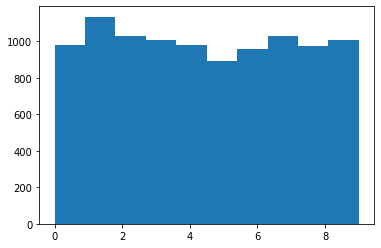

In [141]:
plt.hist([result(i) for i in CurrLabels], bins=10, normed=0)

[0.00816326530612245, 0.009691629955947136, 0.00872093023255814, 0.03861386138613861, 0.019348268839103868, 0.034753363228699555, 0.027139874739039668, 0.011673151750972763, 0.026694045174537988, 0.023785926660059464]


<BarContainer object of 10 artists>

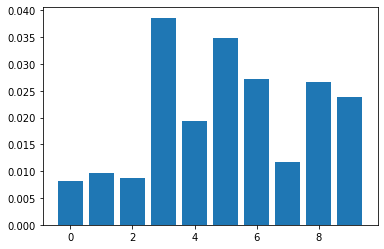

In [138]:
for i in range(10):
    percentage[i] = float(errornumber[i])/float(totalnumber[i])
print(percentage)
plt.bar([i for i in range(10)],percentage)



<BarContainer object of 10 artists>

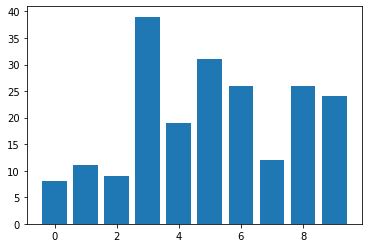

In [139]:
plt.bar([i for i in range(10)],errornumber)